<div style = "color: Black; 
              display: fill;
              border-radius: 12px;
              background-color: #c7a48b;
              box-shadow: rgba(0, 0, 0, 0.15) 0px 10px 5px, rgba(0, 0, 0, 0.12) 0px 6px 6px;">
    <h1 id = "preparation"
        style = "padding: 13px; 
                 color: White;
                 font-size: 24px;
                 font-weight: bold;
                 font-family: Calibri;">1. | Preparation
        <a class="anchor-link" id="preparation" href="https://www.kaggle.com/code/harits/vgg16-asl-recognition-model-explainability#preparation">¶</a>
    </h1>
</div>

In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install imutils

  Preparing metadata (setup.py) ... - \ done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25859 sha256=2abd894d76a46ace84990180b2cb0202bc80cb14ccbc19a6d1dbf96df91a3d6e
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [3]:
# Import Libraries
# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import string
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

# Visualization
import matplotlib
import matplotlib.pyplot as plt
!pip install plotly
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE

# Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
# Configuration
class CFG:
    batch_size = 64
    img_height = 64
    img_width = 64
    epochs = 10
    num_classes = 29
    img_channels = 3
    
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

<div style = "color: Black; 
              display: fill;
              border-radius: 12px;
              background-color: #c7a48b;
              box-shadow: rgba(0, 0, 0, 0.15) 0px 10px 5px, rgba(0, 0, 0, 0.12) 0px 6px 6px;">
    <h1 id = "dataset"
        style = "padding: 13px; 
                 color: White;
                 font-size: 24px;
                 font-weight: bold;
                 font-family: Calibri;">2. | Dataset
        <a class="anchor-link" id="dataset" href="https://www.kaggle.com/code/harits/vgg16-asl-recognition-model-explainability#dataset">¶</a>
    </h1>
</div>

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">2.1. Data Exploration</h2>
</div>

In [5]:
# Labels
TRAIN_PATH = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
labels = []
alphabet = list(string.ascii_uppercase)
labels.extend(alphabet)
labels.extend(["del", "nothing", "space"])
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [6]:
def sample_images(labels):
    # Create Subplots
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(TRAIN_PATH, label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.55, y=0.92)

    # Show
    plt.show()

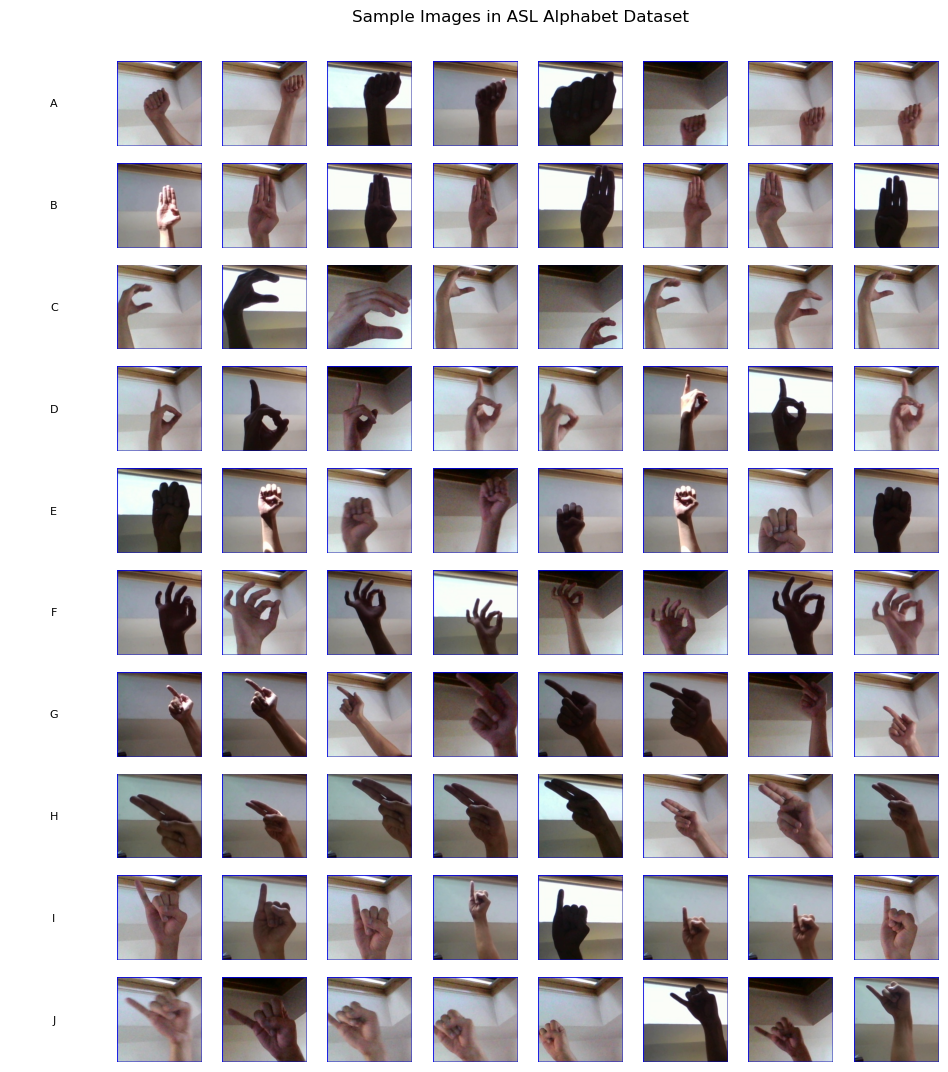

In [7]:
sample_images(labels[:10])

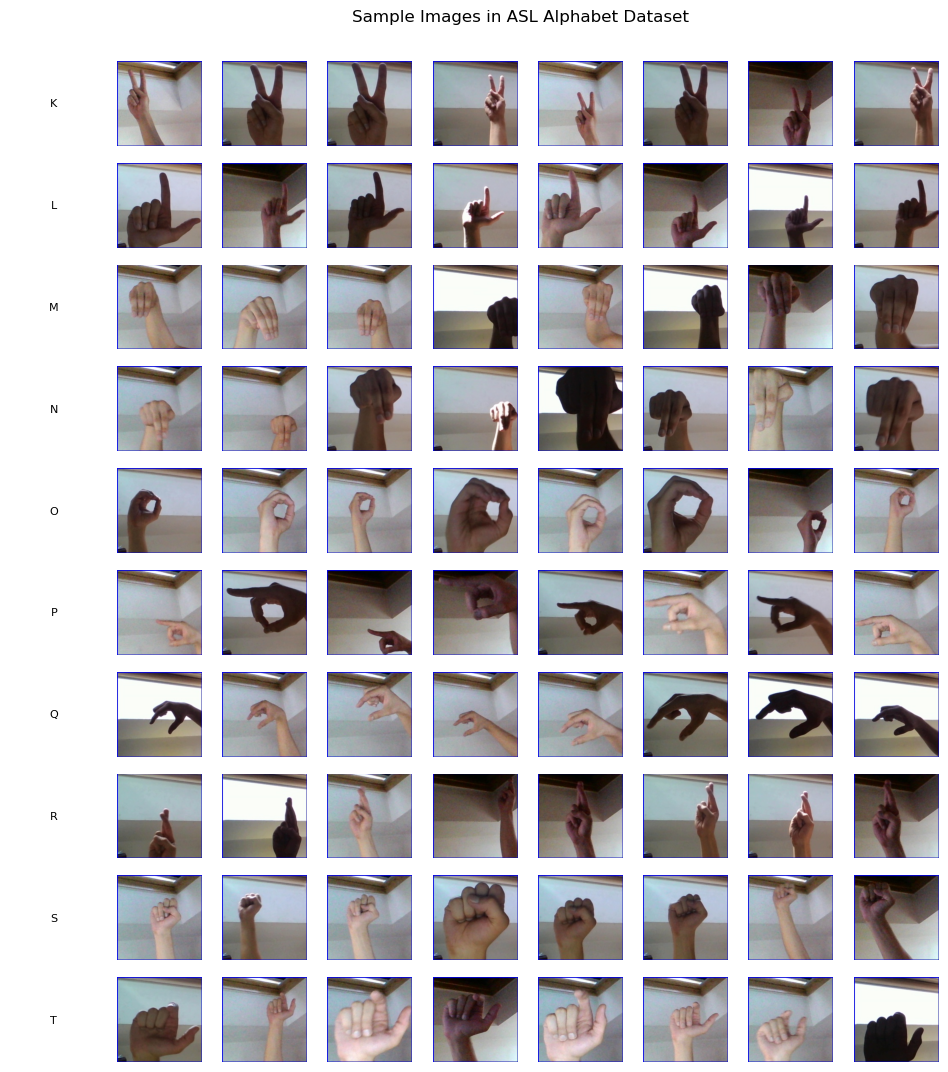

In [8]:
sample_images(labels[10:20])

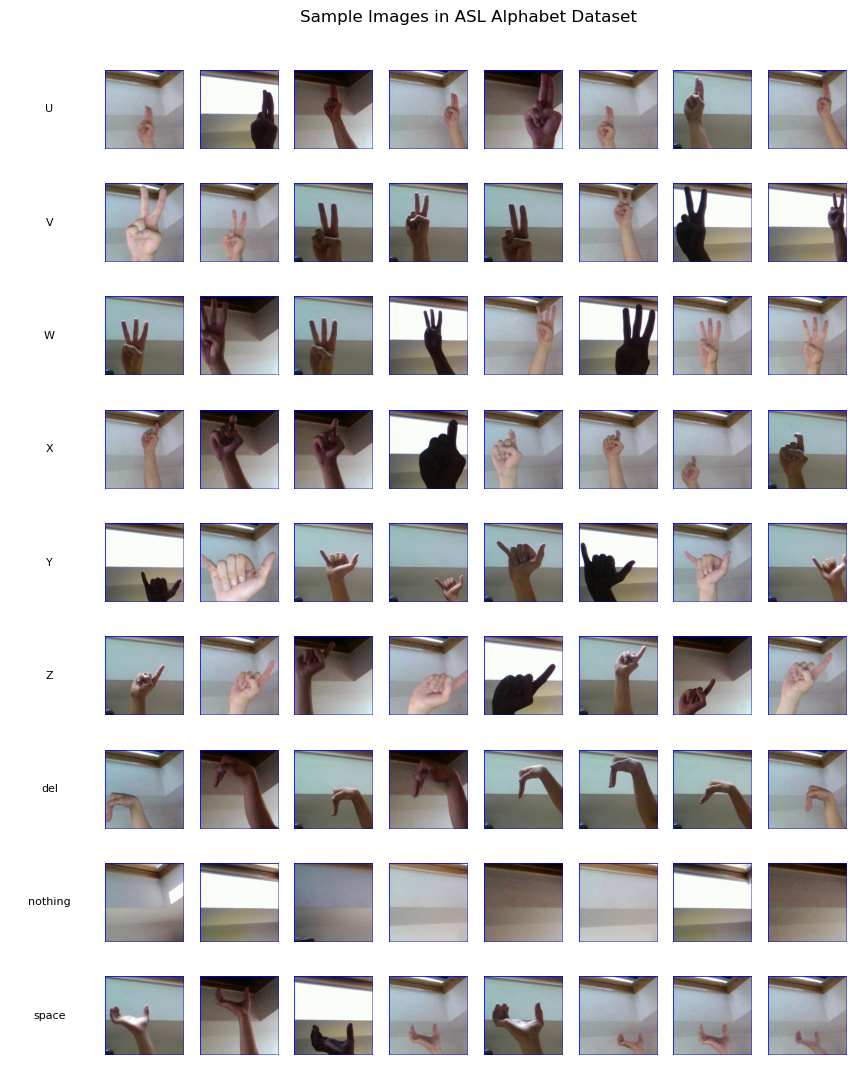

In [9]:
sample_images(labels[20:])

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">2.2. Data Preprocessing</h2>
</div>

In [10]:
# Create Metadata
list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)
    
    sign_label = [label] * len(image_files)
    
    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

,image_path,label
0,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
1,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
2,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
3,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
4,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
...,...,...
86995,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space
86996,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space
86997,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space
86998,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space


In [11]:
# Split Dataset to Train 0.7, Val 0.15, and Test 0.15
X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"], 
    test_size=0.15, 
    random_state=2023, 
    shuffle=True, 
    stratify=metadata["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.70,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

display(data_train)
display(data_val)
display(data_test)

,image_path,label
51901,/kaggle/input/asl-alphabet/asl_alphabet_train/...,R
51887,/kaggle/input/asl-alphabet/asl_alphabet_train/...,R
5050,/kaggle/input/asl-alphabet/asl_alphabet_train/...,B
29446,/kaggle/input/asl-alphabet/asl_alphabet_train/...,J
58405,/kaggle/input/asl-alphabet/asl_alphabet_train/...,T
...,...,...
47111,/kaggle/input/asl-alphabet/asl_alphabet_train/...,P
83611,/kaggle/input/asl-alphabet/asl_alphabet_train/...,nothing
67329,/kaggle/input/asl-alphabet/asl_alphabet_train/...,W
85296,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space


,image_path,label
24961,/kaggle/input/asl-alphabet/asl_alphabet_train/...,I
71053,/kaggle/input/asl-alphabet/asl_alphabet_train/...,X
73637,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y
72875,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y
40669,/kaggle/input/asl-alphabet/asl_alphabet_train/...,N
...,...,...
16474,/kaggle/input/asl-alphabet/asl_alphabet_train/...,F
62741,/kaggle/input/asl-alphabet/asl_alphabet_train/...,U
32281,/kaggle/input/asl-alphabet/asl_alphabet_train/...,K
20451,/kaggle/input/asl-alphabet/asl_alphabet_train/...,G


,image_path,label
73327,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y
85482,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space
65607,/kaggle/input/asl-alphabet/asl_alphabet_train/...,V
53903,/kaggle/input/asl-alphabet/asl_alphabet_train/...,R
64425,/kaggle/input/asl-alphabet/asl_alphabet_train/...,V
...,...,...
40578,/kaggle/input/asl-alphabet/asl_alphabet_train/...,N
28949,/kaggle/input/asl-alphabet/asl_alphabet_train/...,J
42094,/kaggle/input/asl-alphabet/asl_alphabet_train/...,O
5425,/kaggle/input/asl-alphabet/asl_alphabet_train/...,B


In [12]:
# Data Augmentation (Just Rescale)
def data_augmentation():
    datagen = ImageDataGenerator(rescale=1/255.,)
    # Training Dataset
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Validation Dataset
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )
    
    # Testing Dataset
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(CFG.img_height, CFG.img_width),
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

In [13]:
seed_everything(2023)
train_generator, validation_generator, test_generator = data_augmentation()

Found 58103 validated image filenames belonging to 29 classes.
Found 15847 validated image filenames belonging to 29 classes.
Found 13050 validated image filenames belonging to 29 classes.


<div style = "color: Black; 
              display: fill;
              border-radius: 12px;
              background-color: #c7a48b;
              box-shadow: rgba(0, 0, 0, 0.15) 0px 10px 5px, rgba(0, 0, 0, 0.12) 0px 6px 6px;">
    <h1 id = "model-training"
        style = "padding: 13px; 
                 color: White;
                 font-size: 24px;
                 font-weight: bold;
                 font-family: Calibri;">3. | Model Training
        <a class="anchor-link" id="model-training" href="https://www.kaggle.com/code/harits/vgg16-asl-recognition-model-explainability#model-training">¶</a>
    </h1>
</div>

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">3.1. VGG16</h2>
</div>

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

None

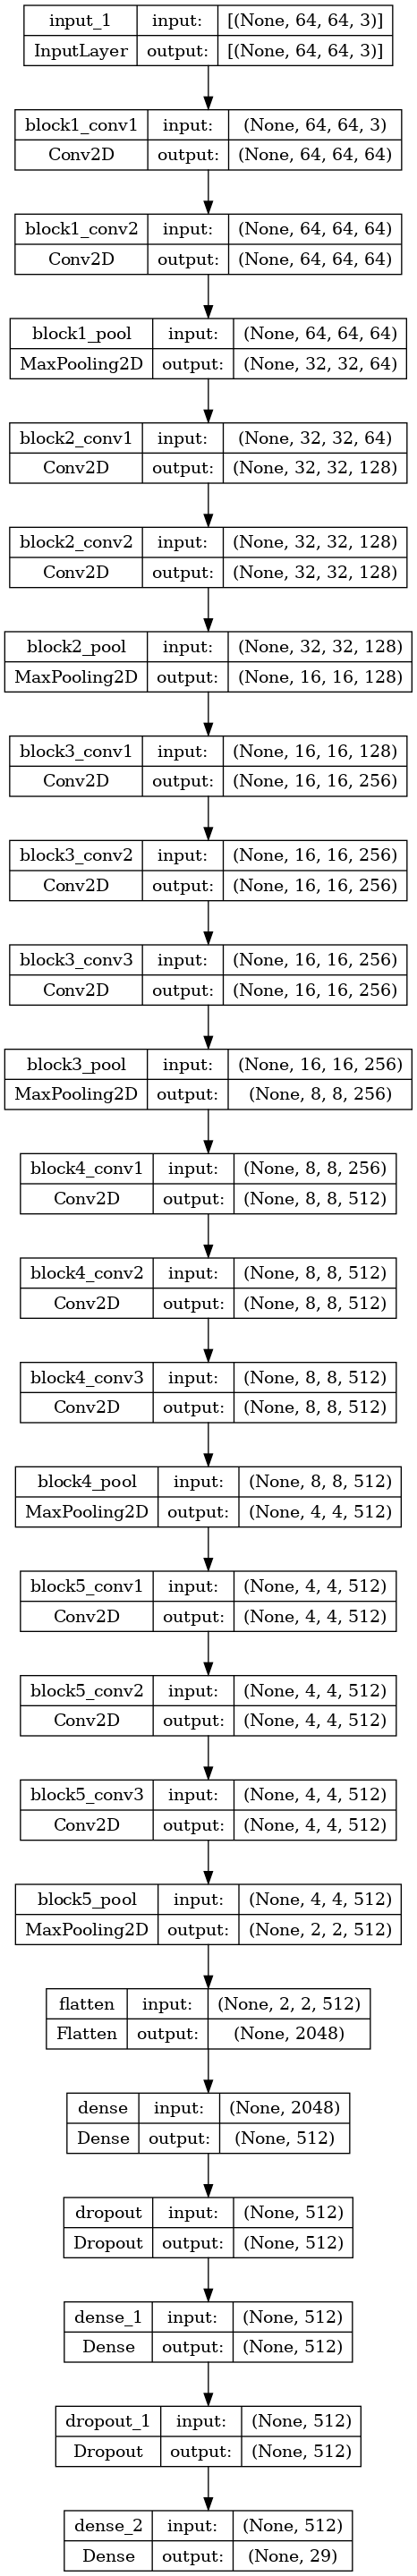

In [14]:
# Load VGG16 model and modify for ASL recognition
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(29, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

display(model.summary())
display(tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True))

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">3.2. Training</h2>
</div>

In [15]:
# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('asl_vgg16_best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [16]:
# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // CFG.batch_size,
    epochs=CFG.epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size,
    callbacks=[checkpoint]
)

Epoch 1/10
907/907 [==============================] - 431s 462ms/step - loss: 1.0920 - accuracy: 0.6581 - val_loss: 0.2681 - val_accuracy: 0.9196
Epoch 2/10
907/907 [==============================] - 146s 161ms/step - loss: 0.3964 - accuracy: 0.8645 - val_loss: 0.1258 - val_accuracy: 0.9632
Epoch 3/10
907/907 [==============================] - 146s 161ms/step - loss: 0.2992 - accuracy: 0.8972 - val_loss: 0.0894 - val_accuracy: 0.9765
Epoch 4/10
907/907 [==============================] - 147s 162ms/step - loss: 0.2465 - accuracy: 0.9161 - val_loss: 0.0701 - val_accuracy: 0.9803
Epoch 5/10
907/907 [==============================] - 146s 160ms/step - loss: 0.2207 - accuracy: 0.9241 - val_loss: 0.0725 - val_accuracy: 0.9773
Epoch 6/10
907/907 [==============================] - 147s 162ms/step - loss: 0.1946 - accuracy: 0.9335 - val_loss: 0.0513 - val_accuracy: 0.9846
Epoch 7/10
907/907 [==============================] - 149s 164ms/step - loss: 0.1813 - accuracy: 0.9396 - val_loss: 0.0523 -

<div style = "color: Black; 
              display: fill;
              border-radius: 12px;
              background-color: #c7a48b;
              box-shadow: rgba(0, 0, 0, 0.15) 0px 10px 5px, rgba(0, 0, 0, 0.12) 0px 6px 6px;">
    <h1 id = "model-evaluation"
        style = "padding: 13px; 
                 color: White;
                 font-size: 24px;
                 font-weight: bold;
                 font-family: Calibri;">4. | Model Evaluation
        <a class="anchor-link" id="model-evaluation" href="https://www.kaggle.com/code/harits/vgg16-asl-recognition-model-explainability#model-evaluation">¶</a>
    </h1>
</div>

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">4.1. Model Testing</h2>
</div>

In [17]:
scores = model.evaluate(test_generator)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", scores[1]*100))

13050/13050 [==============================] - 102s 8ms/step - loss: 0.0350 - accuracy: 0.9905
Evaluate Test Accuracy: 99.05%


<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">4.2. Training Loss and Metrics</h2>
</div>

In [18]:
# Visualize Training and Validation Results

# Create Subplot
fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=["Model Loss", "Model Accuracy"], 
)

# Configuration Plot
class PlotCFG:
    marker_size = 8
    line_size = 2
    train_color = "#76503d"
    valid_color = "#deb392"

# Loss Plot
loss = history.history['loss']
val_loss = history.history['val_loss']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(loss)+1), y=loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Loss"
    ), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_loss)+1), y=val_loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Loss"
    ), row=1, col=1
)

# Accuracy Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(acc)+1), y=acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Accuracy"
    ), row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_acc)+1), y=val_acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Accuracy"
    ), row=1, col=2
)

# Update Axes
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
fig.update_yaxes(title="Categorical Loss", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)

# Update Layout
fig.update_layout(
    title="Training Loss and Metrics", title_x=0.5,
    width=950, height=400,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">4.3. Confusion Matrix</h2>
</div>

In [19]:
# Confusion Matrix
fine_tuned_model = load_model("/kaggle/working/asl_vgg16_best_weights.h5")
predictions = fine_tuned_model.predict(test_generator)

# Get the true labels from the generator
true_labels = test_generator.classes

# Compute the confusion matrix using tf.math.confusion_matrix
confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions.argmax(axis=1),
        num_classes=29)

13050/13050 [==============================] - 59s 4ms/step


In [20]:
# Create Figure
fig = go.Figure()

# Heatmap
fig.add_trace(
    go.Heatmap(
        z=confusion_matrix,
        x=labels,
        y=labels,
        text=confusion_matrix,
        texttemplate="<b>%{text}</b>",
        textfont={"size":8},
        colorscale=[[0, '#f4f4f4'],[1.0, '#76503d']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)

# Update Layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5, font_size=14,
                  width=1050, 
                  height=1115,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()